C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2152\3938497789.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 5.7718e-04 - val_loss: 0.0024
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 2.8173e-04 - val_loss: 0.0022
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 2.7124e-04 - val_loss: 0.0019
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 2.7077e-04 - val_loss: 0.0017
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 2.5302e-04 - val_loss: 0.0017
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 2.3540e-04 - val_loss: 0.0018
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 2.2865e-04 - val_loss: 0.0018
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 2.2453e-04 - val_loss: 0.0019
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 2.2192e-04 - val_loss: 0.0019
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 2.2089e-04 - val_loss: 0.0019
Epoch 12/50
26/26 ━━━━

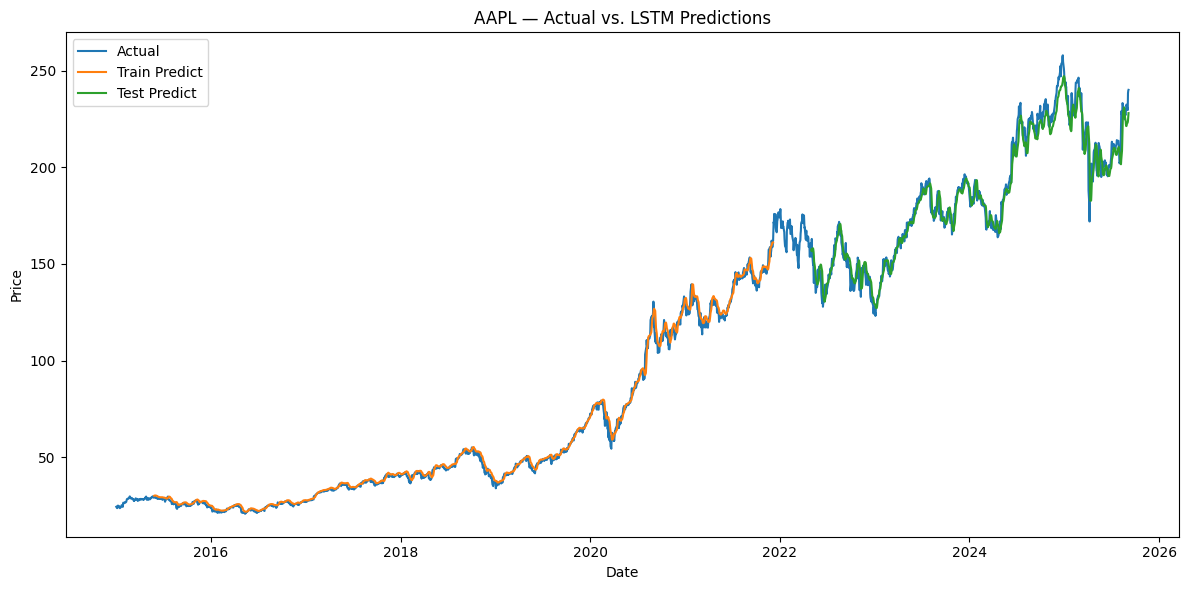

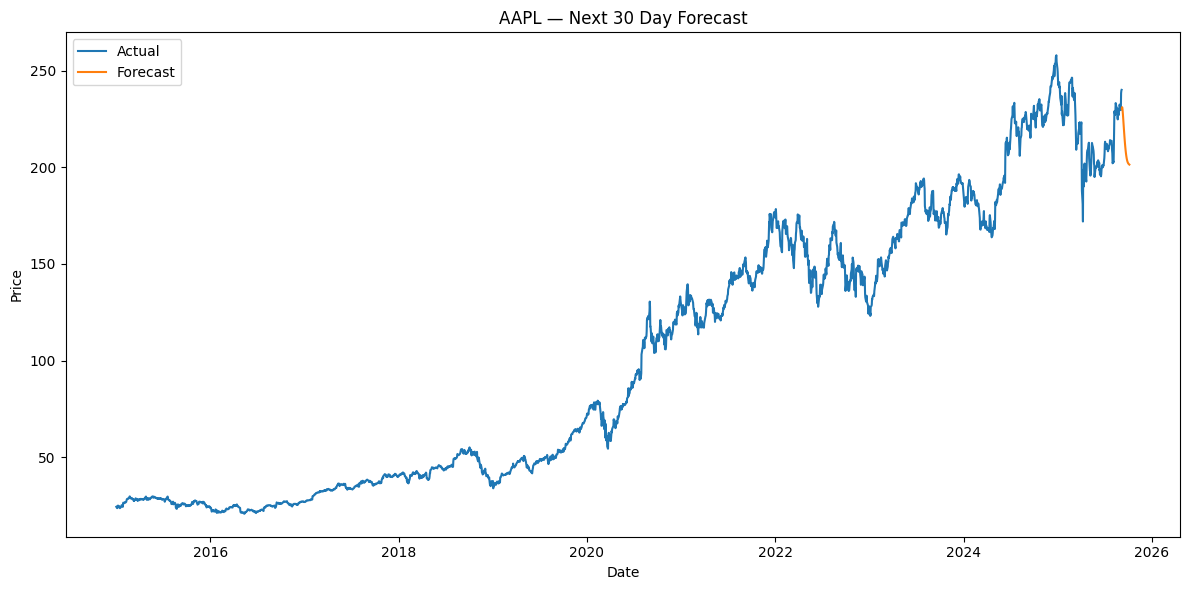

In [1]:
"""
Stock Price Forecasting with Stacked LSTM (TensorFlow/Keras)
- Uses yfinance for data fetching (Yahoo Finance)
- Trains on closing prices
- Evaluates with RMSE (after inverse-transform)
- Plots train/test fit and 30-step naive forecast
"""

import os
import math
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import yfinance as yf  # Changed from pandas_datareader to yfinance

# -----------------------------
# Config
# -----------------------------
TICKER = "AAPL"
START = dt.datetime(2015, 1, 1)
END = dt.datetime.today()

TIME_STEP = 100
EPOCHS = 50
BATCH_SIZE = 64
FUTURE_STEPS = 30
SEED = 42

# Reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Data Fetch
# -----------------------------
def fetch_prices(ticker: str, start: dt.datetime, end: dt.datetime) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if "Adj Close" in df.columns:
        df = df.rename(columns={"Adj Close": "adj_close"})
    return df

df = fetch_prices(TICKER, START, END)

# We’ll use the closing price; choose 'close' or 'Close' or 'adj_close'
close_col_candidates = ["close", "Close", "adj_close"]
close_col = next((c for c in close_col_candidates if c in df.columns), None)
if close_col is None:
    raise RuntimeError(f"Could not find a close column in df columns: {df.columns.tolist()}")

prices = df[[close_col]].copy()
prices.columns = ["close"]  # normalize


# -----------------------------
# Train/Test Split & Scaling
# -----------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all = scaler.fit_transform(prices.values.astype(float))  # shape (N, 1)

training_size = int(len(scaled_all) * 0.65)
train_data = scaled_all[:training_size]
test_data = scaled_all[training_size:]


def create_dataset(dataset: np.ndarray, time_step: int = 1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_dataset(train_data, TIME_STEP)
X_test, y_test = create_dataset(test_data, TIME_STEP)

# Reshape for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# -----------------------------
# Model
# -----------------------------
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(TIME_STEP, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1),
])
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# -----------------------------
# Predict & Inverse Transform
# -----------------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform predictions and ground truths
train_pred_inv = scaler.inverse_transform(train_pred)
test_pred_inv = scaler.inverse_transform(test_pred)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# -----------------------------
# Metrics
# -----------------------------
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")

# -----------------------------
# Plot: Actual vs. Predicted (Train/Test)
# -----------------------------
# Prepare arrays for plotting aligned with the original series length
plot_train = np.full_like(scaled_all, fill_value=np.nan, dtype=float)
plot_test = np.full_like(scaled_all, fill_value=np.nan, dtype=float)

# Train predictions start after TIME_STEP
plot_train[TIME_STEP:TIME_STEP + len(train_pred_inv), 0] = train_pred_inv[:, 0]

# Test predictions start after training_size + TIME_STEP
test_start = training_size + TIME_STEP
plot_test[test_start:test_start + len(test_pred_inv), 0] = test_pred_inv[:, 0]

plt.figure(figsize=(12, 6))
plt.title(f"{TICKER} — Actual vs. LSTM Predictions")
plt.plot(prices.index, prices.values, label="Actual")
plt.plot(prices.index, plot_train, label="Train Predict")
plt.plot(prices.index, plot_test, label="Test Predict")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# -----------------------------
# Forecast FUTURE_STEPS ahead
# -----------------------------
# Start from the last TIME_STEP window of the *entire* scaled series
last_window = scaled_all[-TIME_STEP:].flatten().tolist()
temp = list(last_window)
future_scaled = []

for _ in range(FUTURE_STEPS):
    x_input = np.array(temp[-TIME_STEP:]).reshape((1, TIME_STEP, 1))
    yhat = model.predict(x_input, verbose=0)[0, 0]
    future_scaled.append(yhat)
    temp.append(yhat)

future_inv = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()

# Build future date index (daily frequency, continuing after the last known date)
last_date = prices.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=FUTURE_STEPS, freq="D")

# Combine actuals with forecast for a final plot
plt.figure(figsize=(12, 6))
plt.title(f"{TICKER} — Next {FUTURE_STEPS} Day Forecast")
plt.plot(prices.index, prices["close"].values, label="Actual")
plt.plot(future_dates, future_inv, label="Forecast")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()
